In [14]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [90]:
im5 = pyfits.open('merger_images/dusty_zoom1_total.fits')

wav = np.loadtxt('merger_images/waves_low.dat')

In [88]:
print(im5[0].header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                  500 / length of data axis 1                          NAXIS2  =                  500 / length of data axis 2                          NAXIS3  =                  234 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BSCALE  =                   1.                                                  BZERO   =                   0.                                                  DATE    = '2019-02-15T05:10:21' / Date and time of creation (UTC)               ORIGIN  = 'SKIRT simulation'   / Astrono

Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


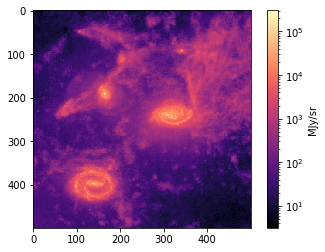

In [61]:

plt.clf()
imag = plt.imshow(np.sum(im5[0].data, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
plt.colorbar(imag, label = 'MJy/sr')
locs, labels = plt.xticks()
print(labels[1], locs)
#plt.xticklabels()
plt.show()
#45 kpc per side

(234, 500, 500) (235,)


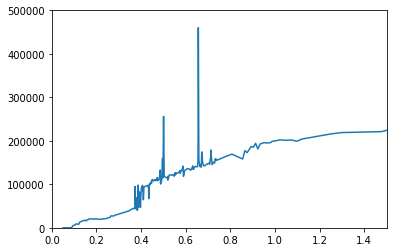

In [73]:
print(np.shape(im5[0].data), np.shape(wav))
SKIRT_spec = np.sum(im5[0].data, axis=(1,2))
plt.clf()
plt.plot(wav[1:], SKIRT_spec)
plt.xlim([0,1.5])
plt.ylim([0,5e5])
plt.show()

[[3.98200012e-01 1.81550585e-07]
 [3.99200012e-01 1.30637330e-07]
 [4.00200012e-01 1.67022593e-07]
 ...
 [2.59619995e+00 6.10641951e-04]
 [2.59719995e+00 5.48364410e-04]
 [2.59819995e+00 5.35720197e-04]]
(2201, 2)


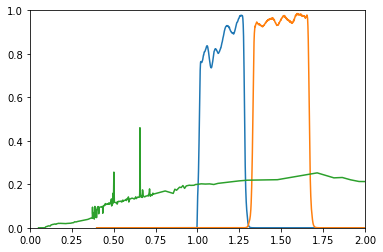

(235,) (234,)


ValueError: A value in x_new is below the interpolation range.

In [86]:
# Try to get individual filter curves
F115W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F115W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F140M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F140M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
print(F115W)
#format is microns and throughput
print(np.shape(F115W))

plt.plot(F115W[:,0], F115W[:,1])
plt.plot(F150W[:,0], F150W[:,1])
plt.plot(wav[1:], SKIRT_spec/1e6)
plt.xlim([0,2])
plt.ylim([0,1])

plt.show()

# Okay how do I select?
#np.convolve(SKIRT_spec)
from scipy import interpolate, fftpack
print(np.shape(wav), np.shape(SKIRT_spec))
int_func = interpolate.interp1d(wav[1:], SKIRT_spec)
int_flux = int_func(F115W[0])

'''int_func = interpolate.interp1d(F115W[0], F115W[1])
int_flux = int_func(wav)'''

In [63]:
# Try to get filter curves up and running:
#! /usr/bin/env/ python

'''plot the components of the optics file...for the TR'''

from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

def replace_nan(items):
    for index, item in enumerate(items):
        if (item == '---'):
            items[index] = float('nan')
    return items


ofile = 'nircam_throughputs/optics/NIRCam_optics_transmission_29Oct2015.csv'

opttab = ascii.read(ofile,header_start=1,data_start=2,format='csv')


wave = opttab['Wavelength'].data.data
nvr_thru = opttab['NVR_Transmission'].data.data
nvr_wave = opttab['NVR_Wavelength'].data.data
collimator = opttab['Collimator'].data.data
sw_triplet = replace_nan(opttab['SW_Triplet'].data.data).astype('float')
sw_mirrors = replace_nan(opttab['SW_Mirrors'].data.data).astype('float')
lw_triplet = replace_nan(opttab['LW_triplet'].data.data).astype('float')
lw_mirrors = replace_nan(opttab['LW_Mirrors'].data.data).astype('float')
sw_particulates = replace_nan(opttab['SW_Particulates'].data.data).astype('float')
lw_particulates = replace_nan(opttab['LW_Particulates'].data.data).astype('float')

#remove extra entries in NVR columns
good = np.where(nvr_wave != 0.)[0]
nvr_thru = nvr_thru[good]
nvr_wave = nvr_wave[good]


#interpolate NVR to the same wavelength scale as the other columns
nvr_interp = np.interp(wave,nvr_wave,nvr_thru)

#combine the elements to produce a SW optics curve and a LW optics curve
#The 0.98 factor is a 'contingency factor' John Stansberry included in a 
#previous version. He said we can keep it out for this version
sw_optics = collimator * sw_triplet * sw_mirrors * sw_particulates #* 0.98
lw_optics = collimator * lw_triplet * lw_mirrors * lw_particulates #* 0.98


f,a = plt.subplots()
a.plot(wave,collimator,color='red',label='Collimator')

a.plot(wave,sw_triplet,color='blue',label='SW Triplet')
a.plot(wave,sw_mirrors,color='black',label='SW Mirrors')
a.plot(wave,sw_particulates,color='green',label='SW Particulates')

a.plot(wave,lw_triplet,color='blue',linestyle='--',label='LW Triplet')
a.plot(wave,lw_mirrors,color='black',linestyle='--',label='LW Mirrors')
a.plot(wave,lw_particulates,color='green',linestyle='--',label='LW Particulates')

a.plot(nvr_wave,nvr_thru,color='orange',label='NVR')

a.plot(wave,sw_optics,color='magenta',label='Total SW')
a.plot(wave,lw_optics,color='magenta',linestyle='--',label='Total LW')

a.set_xlim(0.5,5.5)
a.set_ylabel('Throughput')
a.set_xlabel('Wavelength (microns)')
a.legend(loc='lower right')

f.savefig('Optics_components_plot.pdf')
plt.close(f)
